In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import h5py
import torch

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
np.set_printoptions(precision=2, suppress=False)

cuda:0


# Dataset plotting

For grid of shape ((100, 87), (100, 87)), dx=772, dy=771
For grid of shape ((169, 150), (169, 150)), dx=1e+03, dy=1e+03


Text(0.5, 0.98, 'Illinois, Cook')

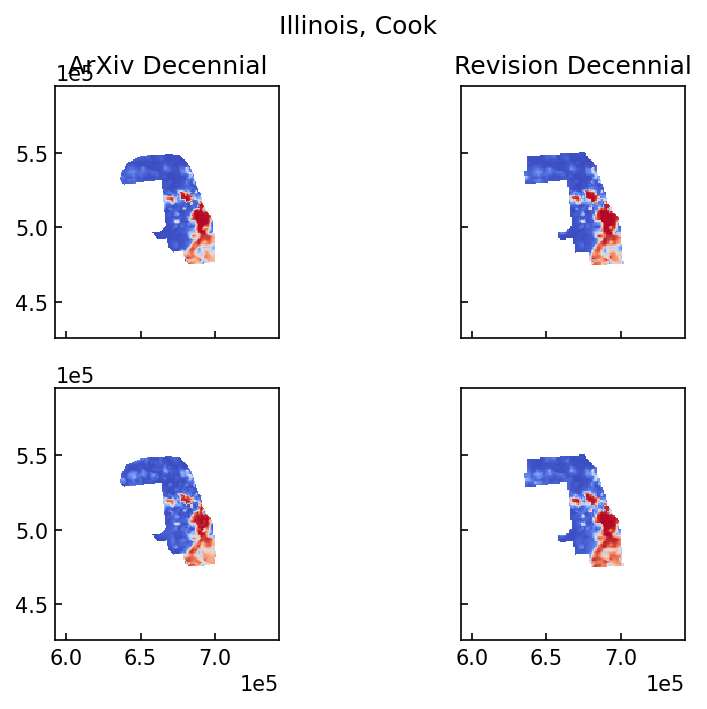

In [2]:
import os
from glob import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import scipy.interpolate as interpolate
import h5py
import matplotlib.pyplot as plt

# Compare the raw data from the first draft to the expanded data used in the revision

data_dir = '/home/jcolen/data/sociohydro/decennial/revision/'

fig, ax = plt.subplots(2, 2, dpi=150, sharex=True, sharey=True)

state = 'Illinois'
county = 'Cook'

with h5py.File(f'/home/jcolen/data/sociohydro/decennial/processed/cook_IL.hdf5', 'r') as h5f:
    dx = h5f['x_grid'][1,1] - h5f['x_grid'][0,0]
    dy = h5f['y_grid'][1,1] - h5f['y_grid'][0,0]
    print(f'For grid of shape {h5f["x_grid"].shape, h5f["y_grid"].shape}, dx={dx:.3g}, dy={dy:.3g}')
    for i in range(2):
        ax[i,0].pcolormesh(h5f['x_grid'], h5f['y_grid'],
                           (h5f['w_grid_array_masked'][:,:,3+i] - h5f['b_grid_array_masked'][:,:,3+i]) / 
                           (h5f['w_grid_array_masked'][:,:,3+i] + h5f['b_grid_array_masked'][:,:,3+i]),
                           vmin=-1, vmax=1, cmap='coolwarm_r', rasterized=True)        

with h5py.File(f'/home/jcolen/data/sociohydro/decennial/revision/gridded/{state}_{county}.hdf5', 'r') as h5f:
    for i, year in enumerate(['2010', '2020']):
        g = h5f[year]
        if i == 0:
            dx = g['x_grid'][1,1] - g['x_grid'][0,0]
            dy = g['y_grid'][1,1] - g['y_grid'][0,0]
            print(f'For grid of shape {g["x_grid"].shape, g["y_grid"].shape}, dx={dx:.3g}, dy={dy:.3g}')
        ax[i,1].pcolormesh(g['x_grid'], g['y_grid'], 
                           (g['white_grid_county'][:] - g['black_grid_county'][:]) / 
                           (g['white_grid_county'][:] + g['black_grid_county'][:]),
                           vmin=-1, vmax=1, cmap='coolwarm_r', rasterized=True)
        
for a in ax.ravel():
    a.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
    a.tick_params(which='both', direction='in')
    a.set_aspect('equal')
ax[0,0].set_title('ArXiv Decennial')
ax[0,1].set_title('Revision Decennial')
fig.suptitle(f"{state}, {county}")

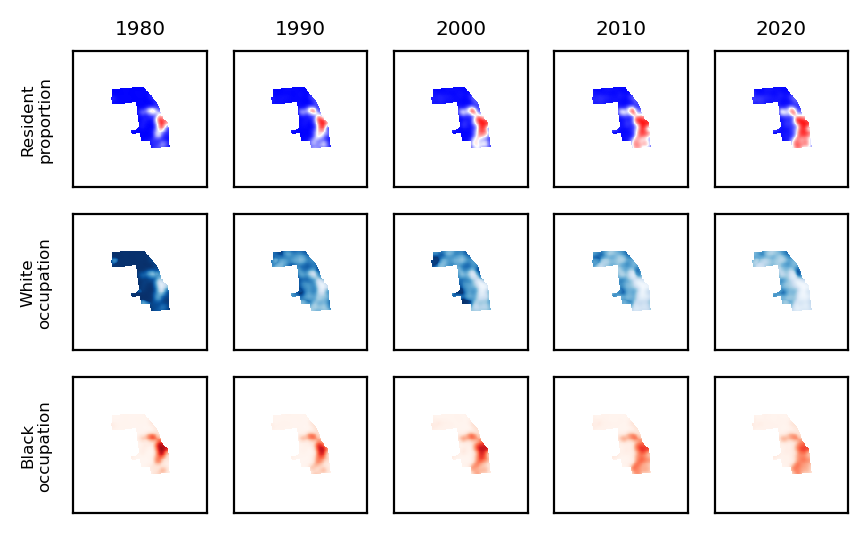

In [8]:
from census_dataset import CensusDataset

plt.rcParams['font.size'] = 6

dataset = CensusDataset('Illinois_Cook')
dataset.validate()

# Look at the time series used for dynamics training

fig, ax = plt.subplots(3, 5, figsize=(5, 3), dpi=200)

for i in range(5):
    wb0 = dataset.wb(1980+i*10)
    ax[0,i].set_title(1980+i*10)
    ax[0,i].pcolormesh(dataset.x, dataset.y, (wb0[0]-wb0[1]) / np.sum(wb0, axis=0), vmin=-1, vmax=1, cmap='bwr_r', alpha=dataset.mask)
    ax[1,i].pcolormesh(dataset.x, dataset.y, wb0[0], vmin=0, vmax=1, cmap='Blues', alpha=dataset.mask)
    ax[2,i].pcolormesh(dataset.x, dataset.y, wb0[1], vmin=0, vmax=1, cmap='Reds', alpha=dataset.mask)
    
ax[0,0].set_ylabel('Resident\nproportion')
ax[1,0].set_ylabel('White\noccupation')
ax[2,0].set_ylabel('Black\noccupation')

for a in ax.flatten():
    a.set(xticks=[], yticks=[])

Text(0, 0.5, '2020 Census')

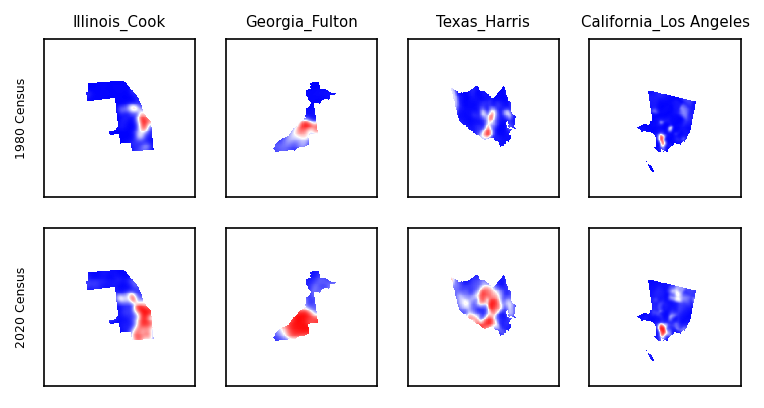

In [9]:
from census_dataset import CensusDataset
from torch.utils.data import ConcatDataset

# Plot the datasets shown in Figure 3

plt.rcParams['font.size'] = 6

fig3_county = [
    'Illinois_Cook',
    'Georgia_Fulton',
    'Texas_Harris',
    'California_Los Angeles'
]
fig, ax = plt.subplots(2, 4, dpi=150, sharex='col', sharey='col', figsize=(6,3))
for i, county in enumerate(fig3_county):
    ds = CensusDataset(county).validate()
    wb = ds[0]['wb']
    ax[0,i].pcolormesh(ds.x, ds.y, (wb[0,0]-wb[0,1])/wb[0].sum(0), cmap='bwr_r', vmin=-1, vmax=1, alpha=ds.mask)
    ax[1,i].pcolormesh(ds.x, ds.y, (wb[-1,0]-wb[-1,1])/wb[-1].sum(0), cmap='bwr_r', vmin=-1, vmax=1, alpha=ds.mask)
    ax[0,i].set_title(county)

for a in ax.flatten():
    a.set(xticks=[], yticks=[])
    
ax[0,0].set_ylabel(f'1980 Census')
ax[1,0].set_ylabel(f'2020 Census')